Example of how to use *revrand* for regression
==============================================

In this notebook we demonstrate *revrand*'s standard linear model (SLM) and generalised linear model (GLM) fitting a random draw from a GP. We also compare the perfomance of these algorithms to a full GP.


In [4]:
%matplotlib inline

import logging

import matplotlib.pyplot as pl
pl.style.use('ggplot')
import numpy as np
from scipy.stats import gamma

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

from revrand import StandardLinearModel, GeneralizedLinearModel, likelihoods, Parameter, Positive
from revrand.metrics import msll, smse
from revrand.utils.datasets import gen_gausprocess_se
from revrand import basis_functions as bs
from revrand.optimize import AdaDelta, Adam

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


## Dataset settings and creation

In [5]:
N = 150  # Number of training points
Ns = 250  # Number of test points
lenscale_true = 1.2
noise_true = 0.1

Xtrain, ytrain, Xtest, ftest = \
            gen_gausprocess_se(N, Ns, lenscale=lenscale_true, noise=noise_true)
ytest = ftest + np.random.randn(Ns) * noise_true
    

## Algorithm Settings

In [6]:
# Common settings
nbases = 20  # Number of unique random bases to use for approximating a kernel
lenscale = gamma(a=1, scale=1)  # Initial value for the lengthscale
var = gamma(a=1, scale=1)  # Initial value for target noise
reg = gamma(a=1, scale=1)  # Initial weight prior

# GLM specific settings
maxiter = 5000
batch_size = 10
updater = Adam()

# Setup random basis functions
base = bs.RandomRBF(Xdim=1, nbases=nbases, lenscale_init=Parameter(lenscale, Positive()))


## Parameter learning


In [7]:
# SLM
slm = StandardLinearModel(base,
                          var=Parameter(var, Positive()),
                          regulariser=Parameter(reg, Positive())
                         )
slm.fit(Xtrain, ytrain)

# GLM
llhood = likelihoods.Gaussian(var_init=Parameter(var, Positive()))
glm = GeneralizedLinearModel(llhood,
                             base,
                             regulariser=Parameter(reg, Positive()),
                             batch_size=batch_size,
                             maxiter=maxiter,
                             updater=updater
                             )
glm.fit(Xtrain, ytrain)

# GP
kern = WhiteKernel(noise_level=np.sqrt(var.mean())) + RBF(length_scale=lenscale.mean())
gp = GaussianProcessRegressor(kernel=kern)
gp.fit(Xtrain, ytrain)



GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=1) + RBF(length_scale=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

## Model Querying


In [8]:
# SLM
Ey_e, Vy_e = slm.predict_moments(Xtest)
Sy_e = np.sqrt(Vy_e)
    
# GLM
Ey_g, Vf_g = glm.predict_moments(Xtest)
Vy_g = Vf_g + glm.like_hypers_
Sy_g = np.sqrt(Vy_g)

# GP
Ey_gp, Sy_gp = gp.predict(Xtest, return_std=True) 
Vy_gp = Sy_gp**2


## Score the models

In [9]:
LL_s = msll(ytest, Ey_e, Vy_e, ytrain)
LL_gp = msll(ytest, Ey_gp, Vy_gp, ytrain)
LL_g = msll(ytest, Ey_g, Vy_g, ytrain)

smse_s = smse(ytest, Ey_e)
smse_gp = smse(ytest, Ey_gp)
smse_glm = smse(ytest, Ey_g)

print("SLM: msll = {}, smse = {}, noise: {}, hypers: {}"
     .format(LL_s, smse_s, np.sqrt(slm.var_), slm.hypers_))
print("GLM: msll = {}, smse = {}, noise: {}, hypers: {}"
     .format(LL_g, smse_glm, np.sqrt(glm.like_hypers_),
             glm.basis_hypers_))
print("GP: msll = {}, smse = {}, noise: {}, hypers: {}"
     .format(LL_gp, smse_gp, gp.kernel_.k1.noise_level,
             gp.kernel_.k2.length_scale))


SLM: msll = -2.2348355990788127, smse = 0.01110818570270761, noise: 0.11323677414407103, hypers: 0.696885448507668
GLM: msll = -1.9916642579998272, smse = 0.018777516797627333, noise: 0.1316216139484752, hypers: 0.40757825856172614
GP: msll = -2.2181321899132134, smse = 0.012410993328591182, noise: 0.012659806828746241, hypers: 1.2762355713883284


## Plot predictions

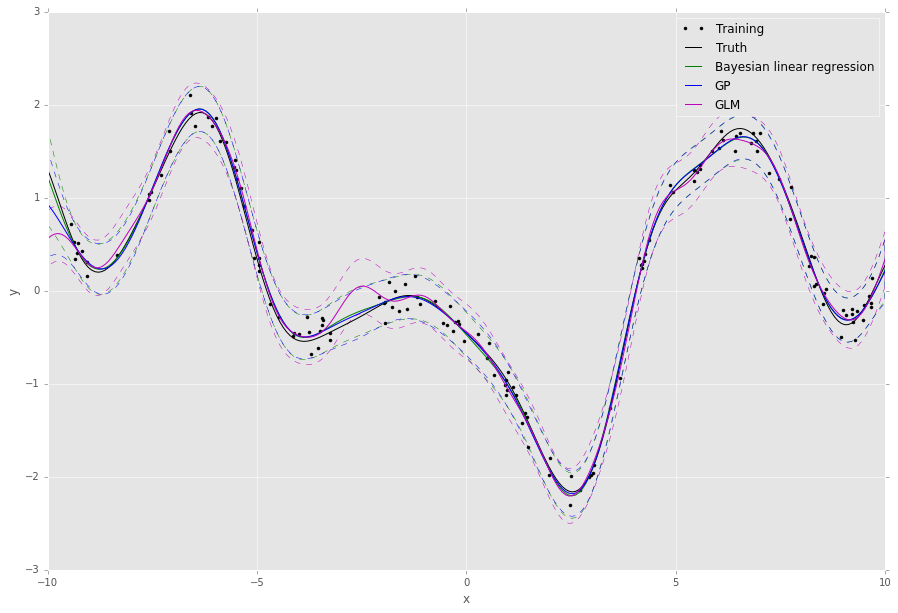

In [10]:
Xpl_t = Xtrain.flatten()
Xpl_s = Xtest.flatten()

# Training/Truth
pl.figure(figsize=(15, 10))
pl.plot(Xpl_t, ytrain, 'k.', label='Training')
pl.plot(Xpl_s, ftest, 'k-', label='Truth')

# ELBO Regressor
pl.plot(Xpl_s, Ey_e, 'g-', label='Bayesian linear regression')
pl.fill_between(Xpl_s, Ey_e - 2 * Sy_e, Ey_e + 2 * Sy_e, facecolor='none',
                edgecolor='g', linestyle='--', label=None)

# GP
pl.plot(Xpl_s, Ey_gp, 'b-', label='GP')
pl.fill_between(Xpl_s, Ey_gp - 2 * Sy_gp, Ey_gp + 2 * Sy_gp,
                facecolor='none', edgecolor='b', linestyle='--',
                label=None)

# GLM Regressor
pl.plot(Xpl_s, Ey_g, 'm-', label='GLM')
pl.fill_between(Xpl_s, Ey_g - 2 * Sy_g, Ey_g + 2 * Sy_g, facecolor='none',
                edgecolor='m', linestyle='--', label=None)

pl.legend()

pl.grid(True)
pl.ylabel('y')
pl.xlabel('x')

pl.show()
